## Description:

    Use DeSeq2 to identify the OTUs that are changing between Control samples from the same dates, but different libraries


# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
#using physeq file with sparsity of greater than 3 in 3 samples
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

physeqFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "metagenomeSeq", "phyloseq", "dplyr", "tidyr", 
           "reshape", "vegan")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.3’
[1] "BiocParallel"
[1] ‘1.0.3’
[1] "doParallel"
[1] ‘1.0.8’
[1] "DESeq2"
[1] ‘1.6.3’
[1] "foreach"
[1] ‘1.4.2’
[1] "ggplot2"
[1] ‘1.0.1’
[1] "gridExtra"
[1] ‘2.0.0’
[1] "scales"
[1] ‘0.3.0’
[1] "metagenomeSeq"
[1] ‘1.11.10’
[1] "phyloseq"
[1] ‘1.10.0’
[1] "dplyr"
[1] ‘0.4.3’
[1] "tidyr"
[1] ‘0.3.1’
[1] "reshape"
[1] ‘0.8.5’
[1] "vegan"
[1] ‘2.3.0’


In [4]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [5]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)

print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 249 samples ]
sample_data() Sample Data:       [ 249 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


### apply gsub across columns replacing __ w/ "" reload tax_table to phyloseq object

In [6]:
%%R
t = tax_table(physeq)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(physeq) = t

In [7]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [8]:
%%R

#re-order levels 
sample_data(physeq.Full)$Plant = relevel(sample_data(physeq.Full)$Plant, "BARE")

#Set DAP as factor
sample_data(physeq.Full)$DAP = factor(sample_data(physeq.Full)$DAP) 
sample_data(physeq.Full)$Rep = factor(sample_data(physeq.Full)$Rep) 
sample_data(physeq.Full)$Library = factor(sample_data(physeq.Full)$Library)
sample_data(physeq.Full)$DAP %>% levels

sample_data(physeq.Full)$PlantRep = interaction(sample_data(physeq.Full)$Rep, sample_data(physeq.Full)$Plant)


In [9]:
%%R
physeq.Full %>% sample_data %>% colnames

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Planted"             "Biomass_P"           "SLA"                
[25] "Leaf_N"              "LeafC_N"             "LNa"                
[28] "Plant_N"             "Plant_C"             "Plant_CN"           
[31] "d15N"                "tN_p"                "BX_activity_g"      
[34] "CB_activity_g"       "LAP_activity_g"      "NAG_activity_g"     
[37] "BX_dif"              "CB_dif"              "LAP_dif"            
[40] "NAG_dif"             "BX_rel"              "CB_rel"             
[43] "

In [10]:
%%R
#subset controls that are can be compared across libraries
physeq.lt = subset_samples(physeq.Full, X.sample %in% 
                           c("sample1-1.06_Nneg", "sample1-1.06_Npos", "sample3-4.27_Npos",
                            "sample4-1.06_Npos", "sample6-2.05_Npos", "sample3-1.06_Nneg",
                            "sample4-4.27_Npos","sample1-2.05_Nneg", "sample1-2.05_Npos", "sample3-4.27_Nneg",
                            "sample4-1.06_Nneg", "sample6-2.05_Nneg", "sample3-1.06_Npos",
                            "sample4-4.27_Nneg"))





# Create DESeq object and view results for Bare and Planted Seperately

## ~Plant + Treatment + Plant:Treatment

In [11]:
%%R
dds = phyloseq_to_deseq2(physeq.lt, ~DAP + Treatment + Library)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: estimating size factors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: estimating dispersions

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: gene-wise dispersion estimates: 20 workers

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: mean-dispersion relationship

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

[1] "Intercept"     "DAP36"         "DAP57"         "DAP61"        
[5] "DAP79"         "TreatmentNneg" "TreatmentNpos" "Library1"     
[9] "Library2"     


In [12]:
%%R
res = results(d_dds, parallel = TRUE, independentFiltering = FALSE)

In [13]:
%%R
summary(res)


out of 4784 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 37, 0.77% 
LFC < 0 (down)   : 23, 0.48% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [20]:
%%R

df = as.data.frame(res[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
    df$OTU = rownames(df)
    df = df[!is.na(df$padj),]

    TT = physeq.lt %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, by = 'OTU')
    

df.sig = d[d$padj <0.1,]
df.sig = df.sig %>% arrange(log2FoldChange) 

## Graph Taxa with significant l2f

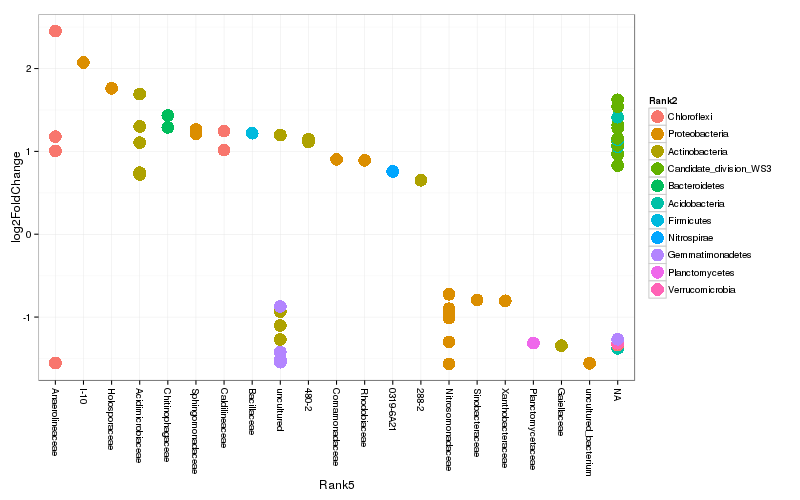

In [26]:
%%R -w 800 -h 500
theme_set(theme_bw())
scale_fill_discrete <- function(palname = "Set1", ...) {
    scale_fill_brewer(palette = palname, ...)
}
# Phylum order
x = tapply(df.sig$log2FoldChange, df.sig$Rank2, function(x) max(x))
x = sort(x, TRUE)
df.sig$Rank2 = factor(as.character(df.sig$Rank2), levels=names(x))
## Genus order
x = tapply(df.sig$log2FoldChange, df.sig$Rank5, function(x) max(x))
x = sort(x, TRUE)
df.sig$Rank5 = factor(as.character(df.sig$Rank5), levels=names(x))
p = ggplot(df.sig, aes(x=Rank5, y=log2FoldChange, color=Rank2)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
p

In [29]:
%%R
pdf(file = "/home/bryan/RhizCG/figures/diagnostics/LibraryL2f.pdf")
print(p)
dev.off()


png 
  2 


## Identify taxa in negative controls

In [15]:
%%R
Control = subset_samples(physeq, X.sample %in% c("Neg_Control_1", "Negative_Control_2"))
Control = prune_taxa(taxa_sums(Control) > 0, Control)
Control

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 62 taxa and 2 samples ]
sample_data() Sample Data:       [ 2 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 62 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 62 tips and 61 internal nodes ]


In [16]:
%%R -w 600 -h 900

p1 = plot_bar(Control, fill = 'Rank2')
p1

#p2 = plot_bar(Control, fill = 'Rank6', x = "Sample")

#grid.arrange(p1, p2, ncol=1)


Error in order(mdf$Abundance, decreasing = TRUE) : 
  argument 1 is not a vector


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in order(mdf$Abundance, decreasing = TRUE) : 
  argument 1 is not a vector

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [17]:
%%R
df.sig.plus = df.sig[df.sig$log2FoldChange > 0,]
d = df.sig.plus[,c(2,3,9,10)]
df.sig.plus[,c(2,3,9,10, 11)] %>% arrange(Rank4, Rank5) %>%
write.csv(file = "/home/bryan/RhizCG/figures/diagnostics/l2f_library_comp.csv",
         sep = ",")

In [18]:
%%R
NegOTU = otu_table(Control) %>% data.frame
NegTax = tax_table(Control) %>% data.frame
NegOTU$OTU = row.names(NegOTU)
NegTax$OTU = row.names(NegTax)
tmp = 
    left_join(NegOTU, NegTax, by = "OTU")
tail(tmp)
colnames(tmp)[1:2] = c("count_Neg2", "count_Neg_1")




In [19]:
%%R
tmp[,c(1,2,7,8,9)] %>% arrange(Rank4, Rank5, Rank6) %>%
write.csv(file = "/home/bryan/RhizCG/figures/diagnostics/neg_controls.csv",
         sep = ",")

## Graph Taxa with significant l2f

In [ ]:
%%R -w 800 -h 500
theme_set(theme_bw())
scale_fill_discrete <- function(palname = "Set1", ...) {
    scale_fill_brewer(palette = palname, ...)
}
# Phylum order
x = tapply(df.sig$log2FoldChange, df.sig$Rank2, function(x) max(x))
x = sort(x, TRUE)
dif.sig$Rank2 = factor(as.character(dif.sig$Rank2), levels=names(x))
## Genus order
x = tapply(dif.sig$log2FoldChange, dif.sig$Rank5, function(x) max(x))
x = sort(x, TRUE)
dif.sig$Rank5 = factor(as.character(dif.sig$Rank5), levels=names(x))
ggplot(dif.sig, aes(x=Rank5, y=log2FoldChange, color=Rank2)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
